In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.3
pymc3 version: 3.6
exoplanet version: 0.1.3


# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

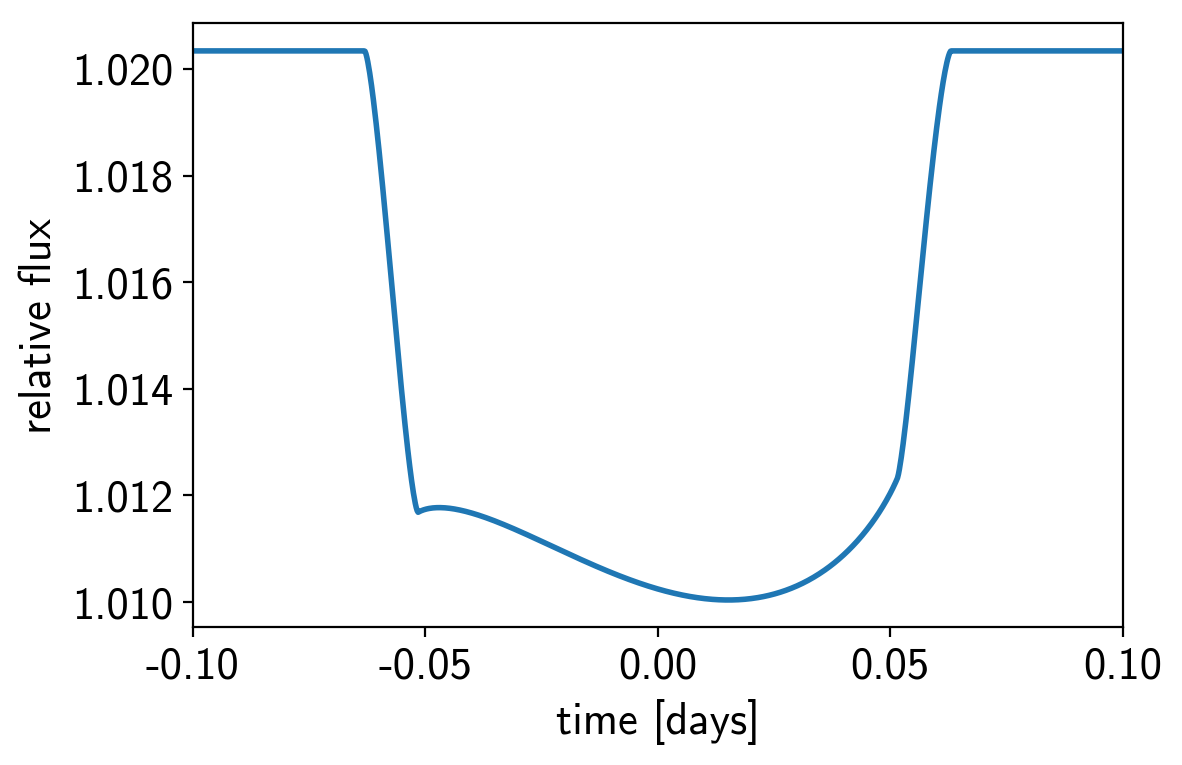

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
from starry.ops import LightCurve

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
lmax = 2
t = np.linspace(-0.1, 0.1, 1000)
np.random.seed(41)
y_true = 0.1 * np.random.randn((lmax + 1) ** 2)
y_true[0] = 1.0
op = LightCurve(lmax)
light_curve = op.get_light_curve(orbit=orbit, r=0.1, t=t, y=y_true).eval()

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
period_true = np.random.uniform(5, 20)
t0_true = period_true * np.random.rand()
t = np.arange(0, 80, 0.02)
fluxerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009) and for the joint radius ratio and impact parameter distribution we'll use the parameterization from [Espinoza (2018)](https://arxiv.org/abs/1811.04859).
Both of these reparameterizations are implemented in *exoplanet* as custom *PyMC3* distributions (:class:`exoplanet.distributions.QuadLimbDark` and :class:`exoplanet.distributions.RadiusImpact` respectively).

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    
    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0_true, sd=1.0)
    
    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(period_true), sd=0.1)
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # Normal distributions for the map coeffs
    y = pm.Normal("y", mu=y_true, sd=1.0, shape=len(y_true))

    # Normal distributions for r and b
    r = pm.Normal("r", mu=0.06, sd=0.01)
    b = pm.Normal("b", mu=0.4, sd=0.03)
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
    
    # Compute the model light curve using starry
    light_curve = op.get_light_curve(orbit=orbit, r=r, t=t, y=y) + mean
    
    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curve", light_curve)
    
    # In this line, we simulate the dataset that we will fit
    flux = xo.eval_in_model(light_curve)
    flux += fluxerr * np.random.randn(len(flux))
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=fluxerr, observed=flux)
    
    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = pm.find_MAP(start=model.test_point)

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 24,793, ||grad|| = 8,719.7: 100%|██████████| 22/22 [00:00<00:00, 630.12it/s]  


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

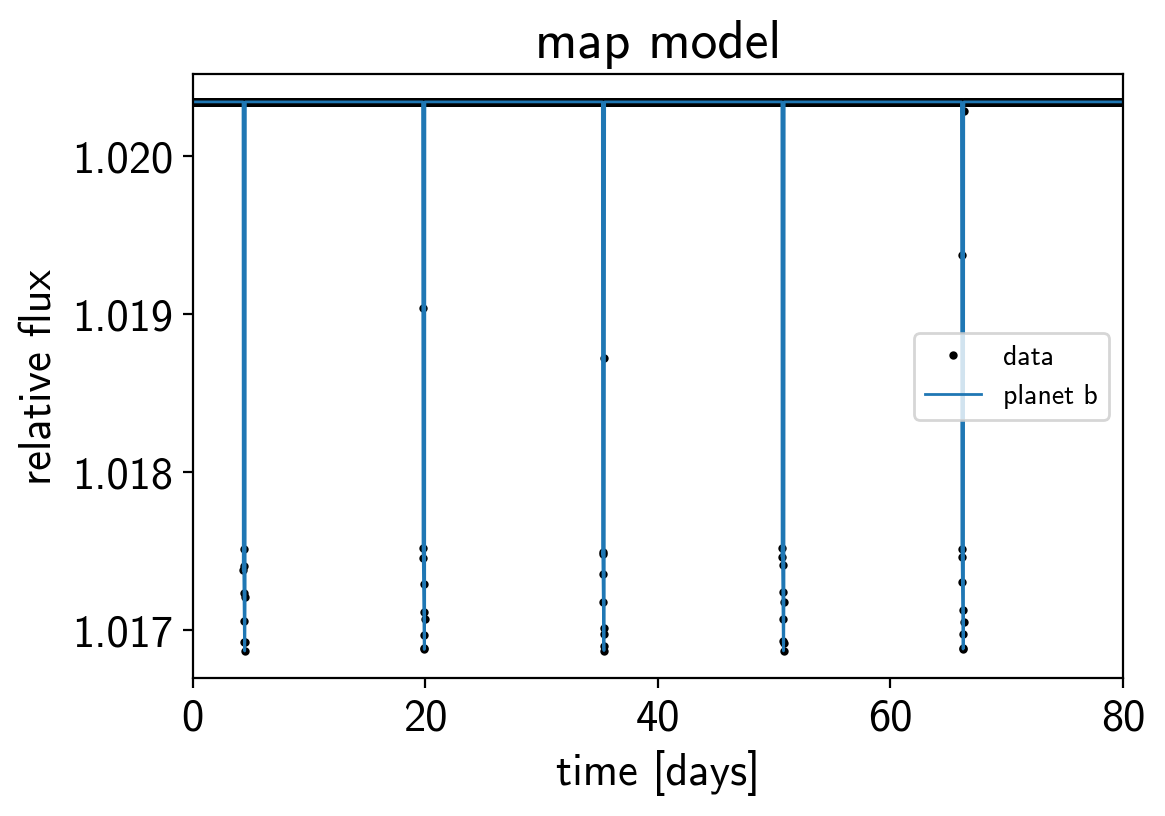

In [6]:
plt.plot(t, flux, ".k", ms=4, label="data")
plt.plot(t, map_soln["light_curve"], lw=1, label="planet {0}".format("b"))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use the :class:`exoplanet.PyMC3Sampler` to sample.

In [7]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains: 100%|██████████| 808/808 [00:13<00:00, 59.64draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, r, y, logP, t0, mean]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:47<00:00, 112.15draws/s]
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7622071291898908, but should be close to 0.9. Try to increase the number of tuning steps.
There were 338 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6650545011044572, but should be close to 0.9. Try to increase the number of tuning steps.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7678903250628842, but should be close to 0.9. Try to increase the number of tuning steps.
There were 138 divergences after tuning. Increase `target_accept`

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "y", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period,15.446869,0.000625,0.000016,15.445752,15.448161,1241.989744,1.002580
t0,4.420319,0.001685,0.000044,4.417200,4.423643,1179.040366,1.002518
r,0.045568,0.007958,0.000423,0.031565,0.060869,194.699985,1.009318
b,0.403383,0.020282,0.000885,0.360411,0.439153,269.371034,1.013666
y__0,1.001334,0.713601,0.014568,-0.355371,2.447231,2010.324078,1.001637
y__1,0.213368,0.884025,0.029408,-1.401978,2.009242,513.111993,1.004718
y__2,0.272947,0.689167,0.018048,-1.105441,1.601170,1061.909049,1.003860
y__3,0.007391,0.692836,0.018641,-1.319213,1.336926,888.927815,1.001470
y__4,0.119109,0.768105,0.020974,-1.374994,1.555378,816.241015,1.001443
y__5,0.285733,0.711624,0.021294,-1.096576,1.683055,592.272935,1.010741


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

In [ ]:
import corner
samples = pm.trace_to_dataframe(trace) #, varnames=["period", "r"])
corner.corner(samples);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

In [ ]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data",
                 zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter));
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [ ]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

In [ ]:
print("\n".join(bib.splitlines()[:10]) + "\n...")